In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PIPS

In [2]:
!pip install evaluate > /dev/null
!pip install transformers > /dev/null
!pip install datasets > /dev/null
!pip install accelerate > /dev/null
!pip install rouge_score > /dev/null
!pip install torchmetrics > /dev/null
!pip install en_core_web_sm > /dev/null
!pip install torchmetrics > /dev/null
!pip install py-rouge > /dev/null
!pip install fasttext > /dev/null
!pip install rank-bm25 > /dev/null

# IMPORTS

In [3]:
import json
import os
import torch
import csv
import random
import re
import gdown

import pandas as pd
import numpy as np

import rouge

import nltk
nltk.download('punkt')

from transformers import pipeline, DataCollatorForLanguageModeling, TextDataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModel, AutoModelForMultipleChoice

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score

from torch.utils.data import Dataset, DataLoader
from torchmetrics.text.rouge import ROUGEScore

from collections import Counter

from tqdm import tqdm

import tensorflow as tf
# import tensorflow_hub as hub

from datasets import Dataset, load_dataset, load_metric, ClassLabel

# import evaluate

import matplotlib.pyplot as plt

from rank_bm25 import BM25Okapi

import fasttext
import fasttext.util

import spacy
nlp = spacy.load('en_core_web_sm')

from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#global variable to set the download and the other phase

DOWNLOAD_FILE_GLOVE = False
DOWNLOAD_FILE_FT = False
DICT_GLOVE_NOT_SAVED = False
WRITE_JSON_DATASET = False

DO_TRAINING = False

MC500 = True
QUALITY = False

# DATASET READ



In [7]:
if MC500:
  url_train = 'https://drive.google.com/uc?id=1bpFHLKkDcrs2vSqpG35e8GVTgvghu2re&export=download'
  url_val = 'https://drive.google.com/uc?id=1bq7YCtWw6LRvJanb9j55vehBZv4Gw82R&export=download'
  url_test = 'https://drive.google.com/uc?id=1bp6Fy-iO4lUHV2qRXwioqFn6Kp3jEwEy&export=download'

  PATH_TRAIN_MC = '/content/mctest-train.parquet'
  PATH_VAL_MC = '/content/mctest-validation.parquet'
  PATH_TEST_MC = '/content/mctest-test.parquet'

  gdown.download(url_train, PATH_TRAIN_MC, quiet=False)
  gdown.download(url_val, PATH_VAL_MC, quiet=False)
  gdown.download(url_test, PATH_TEST_MC, quiet=False)

  df_tr = pd.read_parquet(PATH_TRAIN_MC)
  df_val = pd.read_parquet(PATH_VAL_MC)
  df_te = pd.read_parquet(PATH_TEST_MC)

Downloading...
From: https://drive.google.com/uc?id=1bpFHLKkDcrs2vSqpG35e8GVTgvghu2re&export=download
To: /content/mctest-train.parquet
100%|██████████| 357k/357k [00:00<00:00, 56.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bq7YCtWw6LRvJanb9j55vehBZv4Gw82R&export=download
To: /content/mctest-validation.parquet
100%|██████████| 75.3k/75.3k [00:00<00:00, 77.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bp6Fy-iO4lUHV2qRXwioqFn6Kp3jEwEy&export=download
To: /content/mctest-test.parquet
100%|██████████| 176k/176k [00:00<00:00, 102MB/s]


In [ ]:
if QUALITY :
  url_train = 'https://drive.google.com/uc?id=1s2v6hkkCz5YtFKPV4YzILiVCl2FsC5lk&export=download'
  url_val = 'https://drive.google.com/uc?id=1s7nElKngN0Ahs5dkuKk5lKXqlc8e338h&export=download'

  PATH_TRAIN = '/content/quality_train.csv'
  PATH_VAL = '/content/quality_val.csv'

  gdown.download(url_train, PATH_TRAIN, quiet=False)
  gdown.download(url_val, PATH_VAL, quiet=False)

  df_tr = pd.read_csv(PATH_TRAIN)
  df_val = pd.read_csv(PATH_VAL)

## STATISTICS
Functions to observe the statistics on the dataset. I calculated the distributions lenght of the stories, the questions, the answers and the distribution of the first word of the question.

In [8]:
#function to show with mathplot the graphs on dataset's statistics

def list_length_sent(lista, dict_word):

  stringa = ''
  for elem in lista:
    stringa += elem
    #print(elem)

    doc = nlp(stringa)

    for sent in doc.sents:
      #print('elem in doc.semts:', sent)     #entire phrase
      #print(len(sent), sent)

      if len(sent) not in dict_word:
        dict_word[len(sent)] = 0
      dict_word[len(sent)] += 1
    stringa = ''

  return dict_word

def plt_fre(dict_word, xlabel, ylabel):
  y = dict_word.values()
  x = dict_word.keys()

  # create distribution grafic
  # dim of graphic
  fig, ax = plt.subplots(figsize=(10, 5))

  # graphic personalization
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title('')

  # show graphic
  ax.bar(x, y, width=1)
  plt.xticks(rotation=90)  # 90 degree rotation

  plt.show()

  print(dict_word)

def plot_freq(idx, lista, dict_word, xlabel, ylabel):

  i = 0
  if len(lista) != 0:
    while i < len(lista):
      elem = lista[i]

      if isinstance(elem, dict):
        for key in elem:
          #print(key, elem[key])
          arrotondato = round(len(elem[key]) / 5) * 5
          if arrotondato not in dict_word:
            dict_word[arrotondato] = 0
          dict_word[arrotondato] += 1
      else:
        #print(idx[i]['story'])
        arrotondato = round(len(elem) / 5) * 5
        if arrotondato not in dict_word:
          dict_word[arrotondato] = 0
        dict_word[arrotondato] += 1
      i += 4


  y = dict_word.values()
  x = dict_word.keys()

  # create distribution grafic
  # dim of graphic
  fig, ax = plt.subplots(figsize=(10, 5))

  # graphic personalization
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title('')

  # show graphic
  if len(lista) != 0:
    ax.bar(x, y, width=2.5)
    min_v = min(dict_word.keys())
    max_v = max(dict_word.keys())
    plt.xlim(min_v, max_v+100)
    plt.xticks(rotation=0)  # 90 degree rotation
    print(min_v)
    print(max_v)

  else:
    ax.bar(x, y, width=1)
    plt.xticks(rotation=90)  # 90 degree rotation

  plt.show()

  print(dict_word)

#aux function to create the dictionary with the frquencies of first word in questions
def dict_type_q(dataframe, dictionary):
  for elem in dataframe.loc[:, 'question']:

    first = re.split(r"\s+|'", elem)
    first = first[0].lower()

    if first not in dictionary:
      dictionary[first] = 0
    dictionary[first] += 1

  for elem in dictionary:
    print(elem, ':', dictionary[elem])
  print('')

#auz function to extraplate the right answer from the list with the various options
def extraction_options(answer_option_dict, right_answer):
  options = []
  for key in answer_option_dict:
    options.append(answer_option_dict[key])

  right_ans = answer_option_dict[right_answer]

  map = {'A':0, 'B':1, 'C':2, 'D':3}

  return options, right_ans, map[right_answer]


LENGTH DATASET TRAIN:  1200
LENGTH DATASET VAL:  200
LENGTH DATASET TEST:  600
DISTRIBUTION LENGTH STORIES - TRAIN: 

590
3235


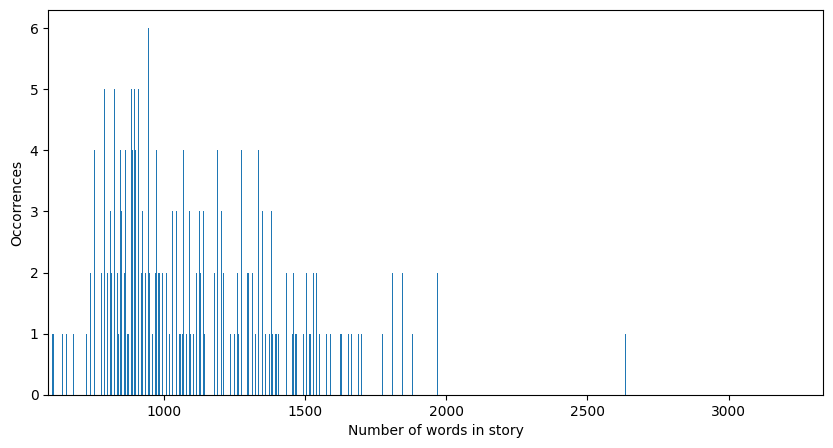

{900: 4, 855: 3, 1400: 1, 925: 3, 865: 4, 1110: 2, 1210: 2, 870: 1, 975: 4, 1875: 1, 1655: 1, 1260: 2, 885: 5, 1045: 3, 830: 3, 930: 2, 895: 5, 1595: 1, 910: 5, 1135: 2, 740: 2, 995: 2, 940: 2, 1380: 3, 680: 1, 880: 2, 805: 3, 1190: 4, 1030: 3, 790: 5, 1180: 2, 1105: 1, 1520: 1, 800: 2, 875: 1, 1000: 6, 1205: 3, 780: 2, 590: 1, 1390: 3, 1300: 2, 945: 6, 1625: 1, 825: 5, 755: 4, 725: 1, 1170: 1, 1185: 2, 1085: 2, 1365: 1, 1330: 1, 770: 2, 1100: 3, 840: 1, 1335: 4, 1435: 2, 915: 2, 1350: 3, 1245: 2, 845: 4, 1455: 1, 905: 3, 1460: 2, 1275: 4, 960: 1, 1280: 1, 1115: 2, 1450: 1, 1550: 1, 1385: 1, 1090: 3, 1125: 3, 1505: 2, 1295: 2, 1130: 2, 1510: 2, 1470: 1, 1405: 1, 1790: 1, 980: 2, 1195: 1, 890: 4, 1590: 1, 1530: 2, 990: 2, 850: 3, 610: 1, 1665: 1, 835: 2, 1010: 2, 950: 2, 1880: 1, 1840: 1, 1305: 2, 1645: 1, 1775: 1, 970: 2, 860: 2, 1360: 1, 1140: 3, 1415: 1, 1255: 3, 920: 2, 1020: 1, 1440: 1, 1845: 2, 1015: 1, 1610: 2, 935: 2, 1265: 1, 965: 4, 1700: 1, 1755: 1, 1630: 1, 1970: 2, 2035: 1,

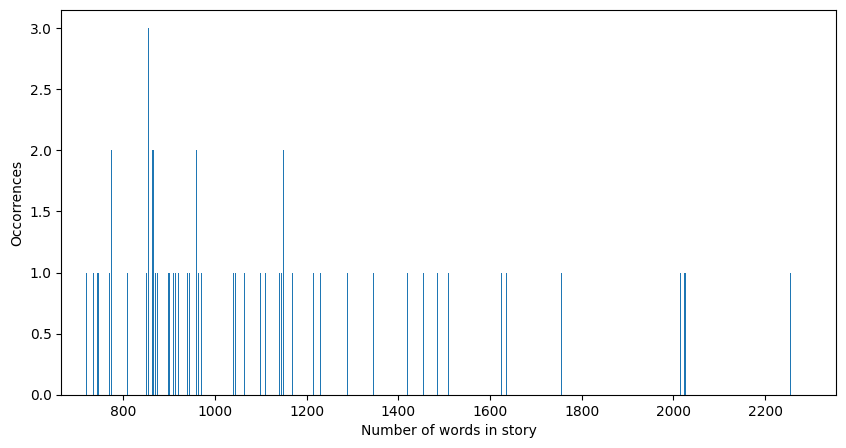

{1625: 1, 865: 2, 945: 1, 875: 1, 1455: 1, 855: 3, 1100: 1, 775: 2, 745: 1, 1140: 1, 900: 1, 1170: 1, 960: 2, 810: 1, 665: 1, 1110: 1, 720: 1, 1755: 1, 1040: 1, 1145: 1, 770: 1, 1290: 1, 1510: 1, 2015: 1, 1150: 2, 1230: 1, 2025: 1, 850: 1, 940: 1, 2255: 1, 1045: 1, 965: 1, 1635: 1, 1345: 1, 970: 1, 1215: 1, 870: 1, 1420: 1, 735: 1, 915: 1, 1065: 1, 1485: 1, 920: 1, 910: 1}
DISTRIBUTION LENGTH STORIES - TEST: 

415
1895


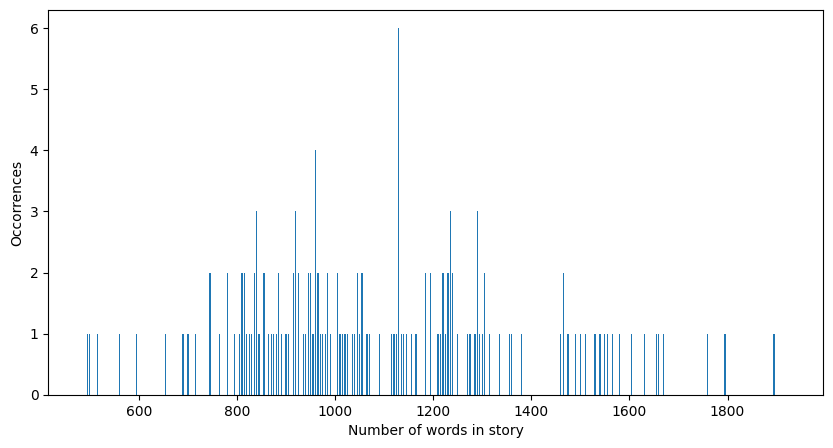

{1225: 1, 815: 2, 1300: 1, 945: 2, 1215: 1, 1130: 6, 845: 1, 1065: 1, 1220: 2, 1285: 1, 905: 1, 655: 1, 700: 1, 1035: 1, 1015: 1, 1185: 2, 965: 2, 840: 3, 1070: 1, 1605: 1, 940: 1, 745: 2, 875: 1, 855: 2, 1655: 1, 985: 2, 1250: 1, 1760: 1, 1240: 2, 1045: 2, 925: 2, 1140: 1, 1530: 1, 795: 1, 1090: 1, 780: 2, 1020: 1, 1565: 1, 1305: 2, 1055: 2, 920: 3, 1145: 1, 1230: 2, 1290: 3, 1120: 1, 1475: 1, 515: 1, 825: 1, 1360: 1, 1540: 1, 560: 1, 1490: 1, 810: 2, 500: 1, 820: 1, 1005: 2, 1895: 1, 915: 2, 1235: 3, 885: 2, 1550: 1, 900: 1, 935: 1, 1795: 1, 950: 2, 980: 1, 835: 2, 1050: 1, 1460: 1, 960: 4, 1510: 1, 690: 1, 595: 1, 1670: 1, 1630: 1, 1125: 1, 805: 1, 1295: 1, 1500: 1, 870: 1, 715: 1, 765: 1, 1155: 1, 1465: 2, 865: 1, 990: 1, 830: 1, 1165: 1, 1580: 1, 880: 1, 1010: 1, 1210: 1, 1275: 1, 1555: 1, 1315: 1, 1025: 1, 1355: 1, 1135: 1, 1380: 1, 1040: 1, 1115: 1, 415: 1, 975: 1, 1660: 1, 1195: 2, 890: 1, 495: 1, 1335: 1, 955: 1, 970: 1, 1270: 1}
DISTRIBUTION LENGTH SENTENCES - TRAIN: 



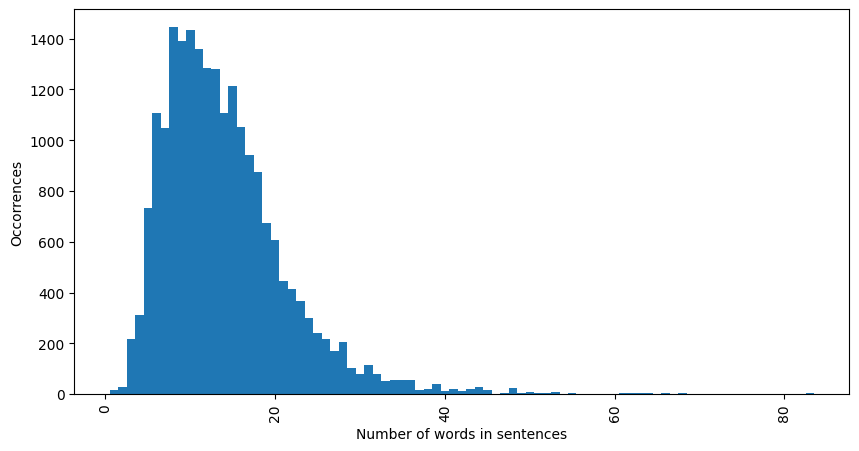

{10: 1432, 5: 732, 6: 1108, 9: 1392, 17: 940, 16: 1052, 12: 1284, 14: 1108, 11: 1360, 8: 1444, 7: 1048, 4: 312, 15: 1212, 3: 216, 35: 56, 13: 1280, 18: 876, 24: 300, 26: 216, 28: 204, 19: 672, 22: 412, 23: 368, 21: 444, 29: 104, 31: 116, 44: 28, 25: 240, 30: 80, 20: 608, 64: 4, 45: 16, 42: 12, 83: 4, 27: 168, 39: 40, 33: 52, 38: 20, 34: 56, 37: 16, 32: 80, 49: 4, 53: 8, 40: 12, 41: 20, 36: 56, 1: 16, 50: 8, 2: 28, 43: 20, 68: 4, 47: 4, 51: 4, 48: 24, 66: 4, 61: 4, 63: 4, 52: 4, 55: 4, 62: 4}
DISTRIBUTION LENGTH SENTENCES - VAL: 



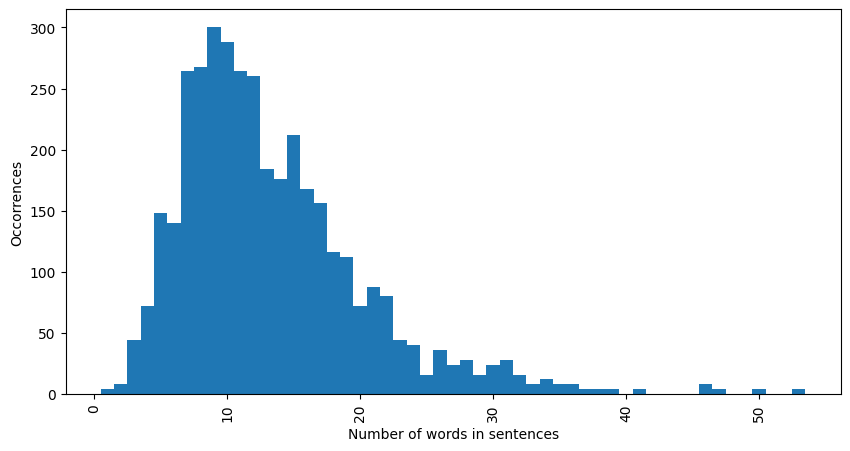

{12: 260, 21: 88, 11: 264, 19: 112, 20: 72, 6: 140, 9: 300, 3: 44, 8: 268, 5: 148, 13: 184, 15: 212, 4: 72, 7: 264, 17: 156, 32: 16, 16: 168, 10: 288, 18: 116, 26: 36, 22: 80, 23: 44, 24: 40, 14: 176, 28: 28, 25: 16, 38: 4, 36: 8, 33: 8, 30: 24, 27: 24, 41: 4, 29: 16, 31: 28, 2: 8, 34: 12, 35: 8, 53: 4, 37: 4, 39: 4, 47: 4, 1: 4, 46: 8, 50: 4}
DISTRIBUTION LENGTH SENTENCES - TEST: 



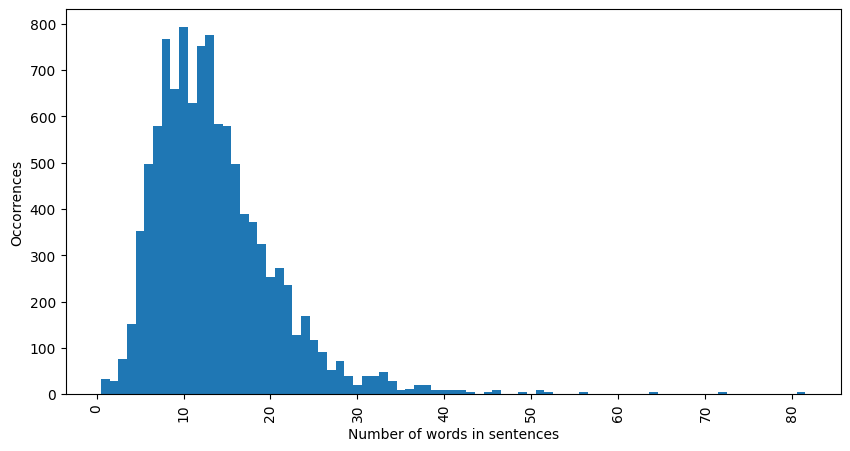

{6: 496, 5: 352, 14: 584, 8: 768, 16: 496, 13: 776, 10: 792, 11: 628, 21: 272, 18: 372, 19: 324, 12: 752, 4: 152, 7: 580, 9: 660, 27: 52, 24: 168, 15: 580, 20: 252, 17: 388, 23: 128, 22: 236, 3: 76, 1: 32, 26: 92, 30: 20, 31: 40, 29: 40, 25: 116, 38: 20, 28: 72, 32: 40, 33: 48, 36: 12, 2: 28, 34: 28, 35: 8, 41: 8, 39: 8, 64: 4, 81: 4, 49: 4, 46: 8, 51: 8, 40: 8, 37: 20, 42: 8, 72: 4, 56: 4, 52: 4, 45: 4, 43: 4}
DISTRIBUTION LENGTH ANSWERS - TRAIN: 

0
135


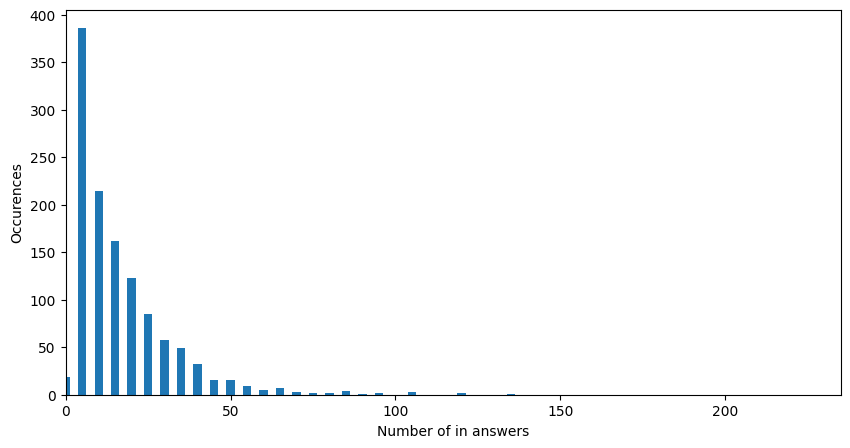

{5: 386, 25: 85, 35: 49, 20: 123, 15: 162, 10: 214, 30: 58, 45: 15, 40: 32, 0: 19, 50: 16, 60: 5, 80: 2, 70: 3, 55: 9, 135: 1, 105: 3, 85: 4, 95: 2, 120: 2, 65: 7, 90: 1, 75: 2}
DISTRIBUTION LENGTH ANSWERS - VAL: 

0
160


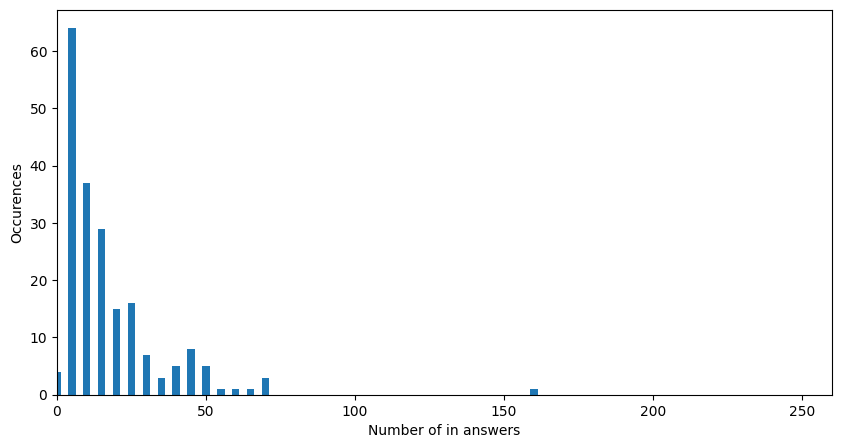

{5: 64, 10: 37, 15: 29, 30: 7, 25: 16, 40: 5, 50: 5, 20: 15, 45: 8, 35: 3, 70: 3, 65: 1, 0: 4, 55: 1, 160: 1, 60: 1}
DISTRIBUTION LENGTH ANSWERS - TEST: 

0
160


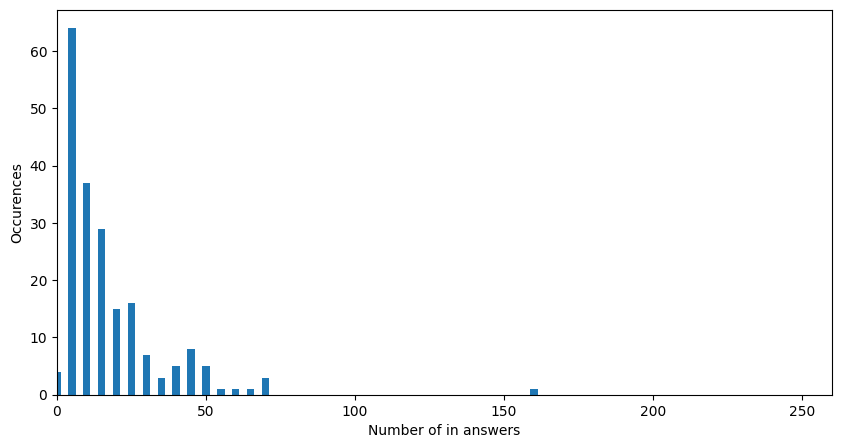

{5: 64, 10: 37, 15: 29, 30: 7, 25: 16, 40: 5, 50: 5, 20: 15, 45: 8, 35: 3, 70: 3, 65: 1, 0: 4, 55: 1, 160: 1, 60: 1}
DISTRIBUTION TYPE QUESTIONS - TRAIN:
what : 620
why : 153
how : 96
at : 2
billy : 1
who : 152
where : 88
in : 2
which : 36
did : 5
whose : 5
when : 23
from : 1
angie : 1
was : 2
if : 1
the : 1
during : 1
ms. : 1
linda : 1
on : 4
after : 1
instead : 1
do : 1
charlie : 1



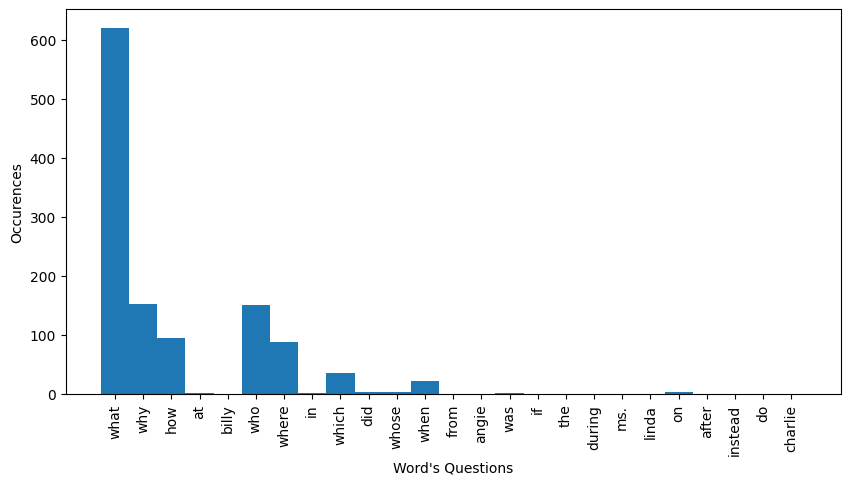

{'what': 620, 'why': 153, 'how': 96, 'at': 2, 'billy': 1, 'who': 152, 'where': 88, 'in': 2, 'which': 36, 'did': 5, 'whose': 5, 'when': 23, 'from': 1, 'angie': 1, 'was': 2, 'if': 1, 'the': 1, 'during': 1, 'ms.': 1, 'linda': 1, 'on': 4, 'after': 1, 'instead': 1, 'do': 1, 'charlie': 1}
DISTRIBUTION TYPE QUESTIONS - VAL:
if : 1
what : 112
where : 23
who : 16
why : 26
how : 11
when : 4
which : 4
did : 1
billy : 1
on : 1



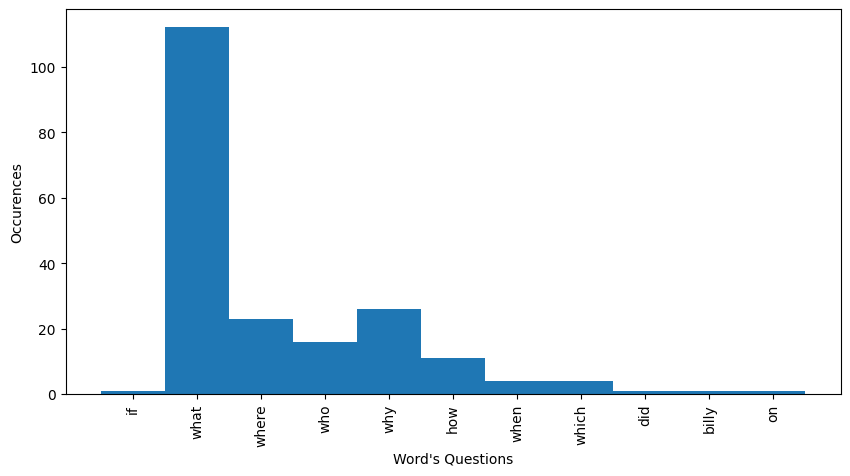

{'if': 1, 'what': 112, 'where': 23, 'who': 16, 'why': 26, 'how': 11, 'when': 4, 'which': 4, 'did': 1, 'billy': 1, 'on': 1}
DISTRIBUTION TYPE QUESTIONS - TEST:
what : 310
who : 76
whose : 3
why : 62
where : 58
how : 42
which : 24
billy : 1
when : 7
in : 3
did : 5
after : 1
was : 1
on : 1
is : 1
the : 2
tim : 1
ryan : 1
according : 1



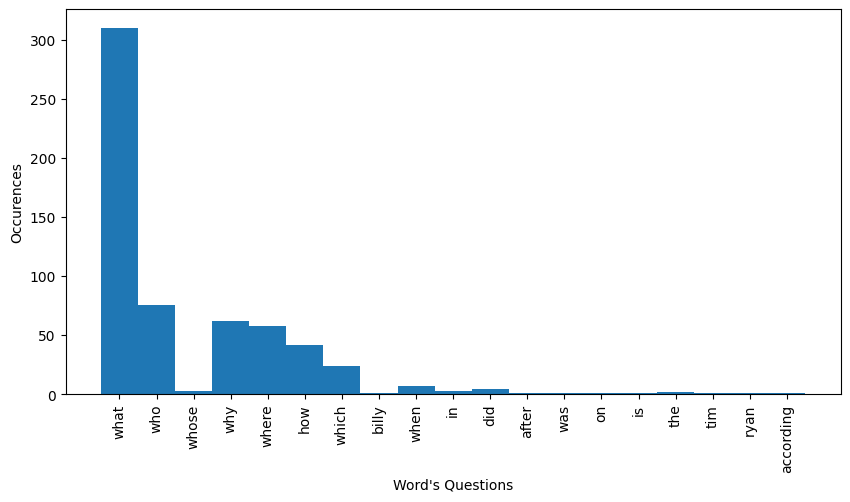

{'what': 310, 'who': 76, 'whose': 3, 'why': 62, 'where': 58, 'how': 42, 'which': 24, 'billy': 1, 'when': 7, 'in': 3, 'did': 5, 'after': 1, 'was': 1, 'on': 1, 'is': 1, 'the': 2, 'tim': 1, 'ryan': 1, 'according': 1}


In [9]:
dict_train_word = {}
dict_val_word = {}
dict_test_word = {}

dict_train_len_sent = {}
dict_val_len_sent = {}
dict_test_len_sent = {}

dict_train_answ = {}
dict_val_answ = {}
dict_test_answ = {}

dict_train_q = {}
dict_val_q = {}
dict_test_q = {}

if MC500:
  #number of question for each set
  print('LENGTH DATASET TRAIN: ', len(df_tr))
  print('LENGTH DATASET VAL: ', len(df_val))
  print('LENGTH DATASET TEST: ', len(df_te))

  print('DISTRIBUTION LENGTH STORIES - TRAIN: \n')
  plot_freq(df_tr.loc[:, 'idx'], df_tr.loc[:, 'story'], dict_train_word, 'Number of words in story', 'Occorrences')
  print('DISTRIBUTION LENGTH STORIES - VAL: \n')
  plot_freq(df_val.loc[:, 'idx'], df_val.loc[:, 'story'], dict_val_word, 'Number of words in story', 'Occorrences')
  print('DISTRIBUTION LENGTH STORIES - TEST: \n')
  plot_freq(df_te.loc[:, 'idx'], df_te.loc[:, 'story'], dict_test_word, 'Number of words in story', 'Occorrences')

  #EXPENSIVE TIME
  print('DISTRIBUTION LENGTH SENTENCES - TRAIN: \n')
  dict_train_len_sent = list_length_sent(df_tr.loc[:, 'story'], dict_train_len_sent)
  plt_fre(dict_train_len_sent, 'Number of words in sentences', 'Occorrences')
  print('DISTRIBUTION LENGTH SENTENCES - VAL: \n')
  dict_train_len_sent = list_length_sent(df_val.loc[:, 'story'], dict_val_len_sent)
  plt_fre(dict_val_len_sent, 'Number of words in sentences', 'Occorrences')
  print('DISTRIBUTION LENGTH SENTENCES - TEST: \n')
  dict_train_len_sent = list_length_sent(df_te.loc[:, 'story'], dict_test_len_sent)
  plt_fre(dict_test_len_sent, 'Number of words in sentences', 'Occorrences')


  print('DISTRIBUTION LENGTH ANSWERS - TRAIN: \n')
  plot_freq(df_tr.loc[:, 'idx'], df_tr.loc[:, 'answer_options'], dict_train_answ, 'Number of in answers' ,'Occurences')
  print('DISTRIBUTION LENGTH ANSWERS - VAL: \n')
  plot_freq(df_val.loc[:, 'idx'], df_val.loc[:, 'answer_options'], dict_val_answ, 'Number of in answers' ,'Occurences')
  print('DISTRIBUTION LENGTH ANSWERS - TEST: \n')
  plot_freq(df_te.loc[:, 'idx'], df_val.loc[:, 'answer_options'], dict_test_answ, 'Number of in answers' ,'Occurences')


  print('DISTRIBUTION TYPE QUESTIONS - TRAIN:')
  dict_type_q(df_tr, dict_train_q)
  plot_freq([], [], dict_train_q, "Word's Questions", "Occurences")
  print('DISTRIBUTION TYPE QUESTIONS - VAL:')
  dict_type_q(df_val, dict_val_q)
  plot_freq([], [], dict_val_q, "Word's Questions", "Occurences")
  print('DISTRIBUTION TYPE QUESTIONS - TEST:')
  dict_type_q(df_te, dict_test_q)
  plot_freq([], [], dict_test_q, "Word's Questions", "Occurences")


if QUALITY:
  print('LENGTH DATASET TRAIN: ', len(df_tr))
  print('LENGTH DATASET VAL: ', len(df_val))

  print('DISTRIBUTION LENGTH STORIES - TRAIN: \n')
  plot_freq([], df_tr.loc[:, 'story'], dict_train_word, 'Number of words in story', 'Occorrences')
  print('DISTRIBUTION LENGTH STORIES - VAL: \n')
  plot_freq([], df_val.loc[:, 'story'], dict_val_word, 'Number of words in story', 'Occorrences')


  print('DISTRIBUTION LENGTH ANSWERS - TRAIN: \n')
  plot_freq([], df_tr.loc[:, 'answer_options'], dict_train_answ, 'Number of in answers' ,'Occurences')
  print('DISTRIBUTION LENGTH ANSWERS - VAL: \n')
  plot_freq([], df_val.loc[:, 'answer_options'], dict_val_answ, 'Number of in answers' ,'Occurences')

  #EXPENSIVE TIME
  print('DISTRIBUTION LENGTH SENTENCES - TRAIN: \n')
  dict_train_len_sent = list_length_sent(df_tr.loc[:, 'story'], dict_train_len_sent)
  plt_fre(dict_train_len_sent, 'Number of words in sentences', 'Occorrences')
  print('DISTRIBUTION LENGTH SENTENCES - VAL: \n')
  dict_train_len_sent = list_length_sent(df_val.loc[:, 'story'], dict_val_len_sent)
  plt_fre(dict_val_len_sent, 'Number of words in sentences', 'Occorrences')


  print('DISTRIBUTION TYPE QUESTIONS - TRAIN:')
  dict_type_q(df_tr, dict_train_q)
  plot_freq([], [], dict_train_q, "Word's Questions", "Occurences")
  print('DISTRIBUTION TYPE QUESTIONS - VAL:')
  dict_type_q(df_val, dict_val_q)
  plot_freq([], [], dict_val_q, "Word's Questions", "Occurences")

In [10]:
#functions to observe the proportion between the label dataset
def freq_label(data):
  dictionary = {}
  for elem in data['answer']:

    if elem not in dictionary:
      dictionary[elem] = 0
    dictionary[elem] += 1

  return dictionary

def print_ratio(data, div):
    my_dict = freq_label(data)

    for key in my_dict:
      my_dict[key] /= div

    return my_dict['A'], my_dict['B'], my_dict['C'], my_dict['D']

In [11]:
print(print_ratio(df_tr, len(df_tr)))
print(print_ratio(df_val, len(df_val)))
if MC500: print(print_ratio(df_te, len(df_te)))

(0.24, 0.23583333333333334, 0.2525, 0.27166666666666667)
(0.275, 0.25, 0.275, 0.2)
(0.235, 0.24333333333333335, 0.24166666666666667, 0.28)


# EXTRACTION OF CONTEXTS

All variables and functions are used to perform context extraction with various types of metrics and embeddings. For each type, I write CSV files where the extracted sentences are 1, 3, 5, 10, and 15 in length.

### Glove Embeddings

In [ ]:
def pre_processing_data(txt_data):

  token_list = []
  sentences_token = []
  token_list_no_stop = []

  #print(type(txt_data), txt_data)

  stringa = ''
  for elem in txt_data:
    stringa += elem

  doc = nlp(stringa)

  for elem in doc.sents:
    #print('elem in doc.semts:', elem)     #entire phrase
    token_list = []
    token_list_no_stop = []
    for token in elem:                   #single word
      if not token.is_space and not token.is_punct:
        token_list.append(token.lemma_.lower())
        if not token.is_stop:
          token_list_no_stop.append(token.lemma_.lower())

    sentences_token.append((token_list, token_list_no_stop))
  return sentences_token

In [ ]:
#NOT EXECUTE YET AFTER THE FIRST DOWNLOAD

#extract the file in specific directory

if DOWNLOAD_FILE_GLOVE:
  !wget -P /content/glove http://nlp.stanford.edu/data/glove.6B.zip
  !unzip /content/glove/glove.6B.zip
  !rm glove.6B.100d.txt glove.6B.200d.txt glove.6B.50d.txt glove.6B.zip
  !ls

In [ ]:
#word embeddings with Glove
#use directory choose before
path_glove_300 = '/content/glove/glove.6B.300d.txt'
path_glove_dict = '/content/glove/dict_glove.npy'

if DICT_GLOVE_NOT_SAVED:

  glove = {}     #embeddinng words dictionary
  EMBEDDING_DIM = 300

  f_glove = open(path_glove_300)
  for line in f_glove:
    word, *vector = line.strip().split(' ')
    glove[word] = vector
    vector_embedding = np.asarray([float(n) for n in vector])
    glove[word] = vector_embedding

  f_glove.close()
  print('Found %s word vectors.' % len(glove))

  np.save(path_glove_dict, glove)

else:
  glove = np.load(path_glove_dict, allow_pickle='TRUE').item()

In [ ]:
print('Found %s word vectors.' % len(glove))

Found 400000 word vectors.


In [ ]:
def glove_translation(glove_dict, sentences_tokenized, question_tokenized):
  glove_q_embedding = []
  glove_q_no_embedding = []

  glove_c_embedding = []
  glove_c_no_embedding = []

  for sent in sentences_tokenized:
    #print('sent delle sentences:tokenized', sent)
    for token in sent[0]:
      if token in glove_dict:
        #print('sent delle sentences:tokenized', token)
        glove_c_embedding.append(glove_dict[token])
      else:
        glove_c_no_embedding.append(token)

  for sent in question_tokenized:
    for token in sent[0]:
      if token in glove_dict:
        glove_q_embedding.append(glove_dict[token])
      else:
        glove_q_no_embedding.append(token)

  return  glove_q_embedding, glove_c_embedding #, glove_a_no_embedding,glove_q_no_embedding

### Tf-Idf

In [ ]:
def tfidf_translation(question, text):

  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform([question] + text)
  question_vector = vectors[0]
  text_vectors = vectors[1:]

  return question_vector, text_vectors

### FastText

In [ ]:
#Set DOWNLOAD_FILE_FT if you need to download the data and choose a destination folder (output)
if DOWNLOAD_FILE_FT:
  url = 'https://drive.google.com/uc?id=1cXrwOzyBVVu2WirUHLeW1VBheH3D4qYJ&export=download'
  output = '/content/cc.en.300.bin'
  gdown.download(url, output, quiet=False)

output = '/content/cc.en.300.bin'

In [ ]:
ft_model = fasttext.load_model(ouput)
crawl_dict = ft_model

def fastText_translation(crawl_dict, question, text):

  try:
    question_vector = crawl_dict.get_sentence_vector(question)
    text_vectors = []

    for sent in text:

      text_vectors.append(crawl_dict.get_sentence_vector(sent))

    similarity = cosine_similarity(question_vector.reshape(1, -1), text_vectors)
    #print(similarity)

    return question_vector, text_vectors
  except:
    return [], []

### BM_25

In [ ]:
def bm_25_scores(story_sentences, query, num_to_extrapolate):
  tokenized_corpus = [doc.split(" ") for doc in story_sentences]
  bm25 = BM25Okapi(tokenized_corpus)
  tokenized_query = query.split(" ")

  doc_scores = bm25.get_scores(tokenized_query)
  #print(doc_scores)
  relevant_sents = bm25.get_top_n(tokenized_query, story_sentences, n=num_to_extrapolate)
  print(relevant_sents)

  return doc_scores.tolist(), relevant_sents

### DPR

In [ ]:
def cls_pooling(model_output, attention_mask):
    return model_output[0][:,0]

# Load model from HuggingFace Hub
tokenizer_dpr = AutoTokenizer.from_pretrained('sentence-transformers/facebook-dpr-question_encoder-single-nq-base')
model_dpr = AutoModel.from_pretrained('sentence-transformers/facebook-dpr-question_encoder-single-nq-base')

def dpr_cosine(sentences, query):

  #print(len(sentences))

  # Tokenize sentences
  encoded_input = tokenizer_dpr(sentences, padding=True, truncation=True, return_tensors='pt')
  encoded_query = tokenizer_dpr(query, padding=True, truncation=True, return_tensors='pt')
  # Compute token embeddings
  with torch.no_grad():
      model_output = model_dpr(**encoded_input)
      model_output1 = model_dpr(**encoded_query)

  # Perform pooling. In this case, max pooling.
  sentence_embeddings = cls_pooling(model_output, encoded_input['attention_mask'])
  sentence_embeddings_q = cls_pooling(model_output1, encoded_input['attention_mask'])

  similarity = cosine_similarity(sentence_embeddings_q.reshape(1,-1), sentence_embeddings)
  #print(type(similarity.tolist()))

  similarity = similarity[0].tolist()
  return similarity

### Rouge

In [ ]:
rouge_obj = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                        max_n=4,
                        limit_length=True,
                        length_limit=100,
                        length_limit_type='words',
                        apply_avg=False, #'Avg',
                        apply_best='Best', #False,
                        alpha=0.5, # Default F1_score
                        weight_factor=1.2,
                        stemming=True)

## Extraction context

In [ ]:
def extract_context(question, text, sim = None,  embedding_dict=None, embedding_type=None, max_sentences=15):
  #print(question, text)
  sent = ''
  i = 0
  similarities = []

  if embedding_type == 'glove':
    #text and question before to a pre processing data, then to glove translations
    text_list = pre_processing_data(text)
    quest_list = pre_processing_data(question)
    question_vector, text_vectors = glove_translation(embedding_dict, text_list, quest_list)
  if embedding_type == 'tfidf':
    question_vector, text_vectors = tfidf_translation(question, text)
  if embedding_type == 'fasttext':
    question_vector, text_vectors = fastText_translation(embedding_dict, question, text)
    if question_vector != []:
      similarities = cosine_similarity(question_vector.reshape(1, -1), text_vectors)
      similarities = similarities[0].tolist()
    else: similarities = []

  if embedding_type == 'dpr':
    similarities = dpr_cosine(text, question)

  if embedding_type == 'bm_25':
    similarities, text = bm_25_scores(text, question, max_sentences)

  if sim == 'cosine':
    similarities = cosine_similarity(question_vector, text_vectors).flatten()

  if sim == 'rouge':
    for s in text:
      try:
        rouge_scores = rouge_obj.get_scores(question, s)
        rouge_1_score = rouge_scores["rouge-1"]['f']
        similarities.append(rouge_1_score)
      except:
        continue

    print(rouge_1_score)


  ranked_sentences = sorted(((similarity, sentence) for similarity, sentence in zip(similarities, text)), reverse=True)
  #print('RANKED SENTENCES', ranked_sentences)

  relevant_sentences = []
  for similarity, sentence in ranked_sentences:
    relevant_sentences.append(sentence)
    i += 1
    sent += sentence
    if i >= max_sentences:
      break
  #print(len(relevant_sentences))
  return sent, relevant_sentences

In [ ]:
#function where I do the extraction and write the file with the extraction, the question, the single answer option, the right answer and the label
def file_extract_context(dataframe, dir_path, file_name, n, mod_sim = None, glove = None):
  #file_path for each extraction file
  file_path1 = dir_path + str(1) + file_name
  file_path3 = dir_path + str(3) + file_name
  file_path5 = dir_path + str(5) + file_name
  file_path10 = dir_path + str(10) + file_name
  file_path15 = dir_path + str(15) + file_name

  f1 = open(file_path1, 'a+', newline='')
  f3 = open(file_path3, 'a+', newline='')
  f5 = open(file_path5, 'a+', newline='')
  f10 = open(file_path10, 'a+', newline='')
  f15 = open(file_path15, 'a+', newline='')

  writer1 = csv.writer(f1)
  writer3 = csv.writer(f3)
  writer5 = csv.writer(f5)
  writer10 = csv.writer(f10)
  writer15 = csv.writer(f15)

  writer1.writerows([['story', 'question', 'A', 'B', 'C', 'D', 'answer', 'label']])
  writer3.writerows([['story', 'question', 'A', 'B', 'C', 'D', 'answer', 'label']])
  writer5.writerows([['story', 'question', 'A', 'B', 'C', 'D', 'answer', 'label']])
  writer10.writerows([['story', 'question', 'A', 'B', 'C', 'D', 'answer', 'label']])
  writer15.writerows([['story', 'question', 'A', 'B', 'C', 'D', 'answer', 'label']])
  i = 0
  while i < (len(dataframe)):
    print(i)

    row15 = ''
    row1 = ''
    row3 = ''
    row5 = ''
    row10 = ''

    story = dataframe['story'][i]
    q = dataframe['question'][i]

    sentences_tokenized = []    #list of sentencens of document

    doc = nlp(story)

    for elem in doc.sents:
      #print(elem)
      sent =str(elem).replace("\\newline", "")
      sent = sent.replace("\\tab", "")
      sent = sent.replace("\n", "")
      sentences_tokenized.append(sent)

    #print(len(sentences_tokenized))

    row15, context = extract_context(q, sentences_tokenized, embedding_dict = glove, embedding_type='tfidf', max_sentences=n, sim = mod_sim )
    print(context)

    #no for quality
    #_, right_ans, label_num = extraction_options(dataframe['answer_options'][i], dataframe['answer'][i])

    #print(right_ans, label_num)

    for item, s in enumerate(context):
      if item < 1: row1 += s
      if item < 3: row3 += s
      if item < 5: row5 += s
      if item < 10: row10 += s

    # print(type(row1))
    # print(type(dataframe['question'][i]))
    # print(type(dataframe['A'][i]))
    # print(type(dataframe['B'][i]))
    # print(type(dataframe['C'][i]))
    # print(type(dataframe['D'][i]))
    # print(type(dataframe['answer'][i]))
    # print(type(dataframe['label'][i]))

    writer1.writerows([[row1 , dataframe['question'][i], dataframe['A'][i], dataframe['B'][i], dataframe['C'][i], dataframe['D'][i], dataframe['answer'][i], str(dataframe['label'][i])]])
    writer3.writerows([[row3 , dataframe['question'][i], dataframe['A'][i], dataframe['B'][i], dataframe['C'][i], dataframe['D'][i], dataframe['answer'][i], str(dataframe['label'][i])]])
    writer5.writerows([[row5 , dataframe['question'][i], dataframe['A'][i], dataframe['B'][i], dataframe['C'][i], dataframe['D'][i], dataframe['answer'][i], str(dataframe['label'][i])]])
    writer10.writerows([[row10 , dataframe['question'][i], dataframe['A'][i], dataframe['B'][i], dataframe['C'][i], dataframe['D'][i], dataframe['answer'][i], str(dataframe['label'][i])]])
    writer15.writerows([[row15, dataframe['question'][i], dataframe['A'][i], dataframe['B'][i], dataframe['C'][i], dataframe['D'][i], dataframe['answer'][i], str(dataframe['label'][i])]])
    i += 1

In [ ]:
#This piece of code is modified for each type of extraction that needs to be performed, with adjustments made to the function parameters.
mod_sim = 'cosine'

root = '/content/contexts_mc500/cosine_tf_idf/'
rel_tr = '_relevant_train_cosine_labelnum.csv'
rel_val = '_relevant_val_cosine_labelnum.csv'
rel_te = '_relevant_test_cosine_labelnum.csv'

file_extract_context(df_tr, root, rel_tr , 15, mod_sim)
file_extract_context(df_val, root, rel_val, 15, mod_sim)
file_extract_context(df_te, root, rel_te, 15, mod_sim)

### Check None rows - splitting quality dataset

Some rows contain None fields, which were removed. After that, the datasets were divided to create a split between the training, validation, and test set, with proportions of 70%, 15%, and 15% respectively. The original test set does not include labels, which is why this system was devised.



In [ ]:
#check None rows

def remove_none(val_data):
  j = 0
  c = 0
  list_none = []

  for i in range(len(val_data)):

      prompt = val_data['story'][i]
      if val_data['story'][i] == None:
        print(j, prompt)
        list_none.append(j)
        c += 1
      if val_data['question'][i] == None:
        print(j, val_data['question'][i])
        list_none.append(j)
        c += 1
      if val_data['A'][i] == None:
        print(j, val_data['A'][i])
        list_none.append(j)
        c += 1
      if val_data['B'][i] == None:
        print(j, val_data['B'][i])
        list_none.append(j)
        c += 1
      if val_data['C'][i] == None:
        print(j, val_data['C'][i])
        list_none.append(j)
        c += 1
      if val_data['D'][i] == None:
        print(j, val_data['D'][i])
        list_none.append(j)
        c += 1

      j += 1

  print(c)
  return list_none

In [ ]:
## To create test set for quality dataset
#To make for each context
#check None rows and split the dataset in 70% training set, 15% validation set and 15% test set

listn = [1, 3, 5, 10, 15]

for elem in listn:
  path_tr = '/content/contexts_quality/rouge/'+str(elem)+'_relevant_train_rouge_labelnum.csv'
  path_val = '/contentcontexts_quality/rouge/'+str(elem)+'_relevant_val_rouge_labelnum.csv'

  df_tr = pd.read_csv(path_tr)
  df_val = pd.read_csv(path_val)

  train_data = Dataset.from_pandas(df_tr)
  val_data = Dataset.from_pandas(df_val)

  list_none_tr = remove_none(train_data)
  list_none_val = remove_none(val_data)

  df_tr = df_tr.drop(list_none_tr)
  df_val = df_val.drop(list_none_val)


  #to dived the sets to have 70% training set, 15% validation set and 15% test set
  index = len(df_tr)+len(df_val)*0.7
  index = index - len(df_tr)

  df_tr = pd.concat([df_tr, df_val[:index]], ignore_index=True)

  parts = np.array_split(df_val[index:], 2)
  df_val = parts[0]
  df_te = parts[1]

  print(len(df_tr))
  print(len(df_val))
  print(len(df_te))

  df_tr.to_csv('/content/new_contexts_quality/rouge/'+str(elem)+'_relevant_train_rouge_labelnum.csv', sep=',', encoding='utf-8', index=False)
  df_val.to_csv('/content/new_contexts_quality/rouge/'+str(elem)+'_relevant_val_rouge_labelnum.csv', sep=',', encoding='utf-8', index=False)
  df_te.to_csv('/content/new_contexts_quality/rouge/'+str(elem)+'_relevant_test_rouge_labelnum.csv', sep=',', encoding='utf-8', index=False)


# MODELS - Bert Multiple Choice

## TRAINING

With the variable MODEL we impose the model to do the training phase

In [ ]:
MODEL  = 'albert'

if MODEL == 'bert': model_checkpoint = "bert-base-uncased"
if MODEL  == 'roberta': model_checkpoint = "roberta-base"
if MODEL == 'albert': model_checkpoint = "albert-base-v2"

# model_checkpoint = "microsoft/deberta-v2-xlarge"    ## GPU PROBLEM
# model_checkpoint = "allenai/longformer-base-4096"   ## GPU PROBLEM

#loading the model using the Huggingface Transformers class "AutoModelForMultipleChoice"
#model_checkpoint used also for autotokenizer, check the corresponding model
model = AutoModelForMultipleChoice.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)  # use_fast=True to the call fast tokenizers, but if you got an error with the previous call, remove that argument

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#context's path for training

#modify singular path
train_path = '/content/contexts_mc500/cosine_dpr/1_relevant_train_cosine_labelnum.csv'
val_path = '/content/contexts_mc500/cosine_dpr/1_relevant_val_cosine_labelnum.csv'
#test_path = '/content/contexts_mc500/cosine_dpr/10_relevant_test_cosine_labelnum.csv'

df_tr = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
#df_te = pd.read_csv(test_path)

In [ ]:
ending_names = ["A", "B", "C", "D"]

def preprocess_function(pandas_frame):
  # Repeat each context four times to go with the four possibilities of answer.
  first_sentences = [[context] * 4 for context in pandas_frame["story"]]
  # Grab all second sentences possible for each context.
  question_headers = pandas_frame["question"]
  second_sentences = [[f"{header} {pandas_frame[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]

  # Flatten
  first_sentences = sum(first_sentences, [])
  second_sentences = sum(second_sentences, [])

  # Tokenize
  tokenized_pandas_frame = tokenizer(first_sentences, second_sentences, truncation=True)#, padding = True)

  # Un-flatten
  return {k: [v[i:i+4] for i in range(0, len(v), 4)] for k, v in tokenized_pandas_frame.items()}

In [ ]:
#Mapping each set with the function preprocess_function

train_data = Dataset.from_pandas(df_tr)
val_data = Dataset.from_pandas(df_val)
#test_data = Dataset.from_pandas(df_te)

dataset_train = train_data.map(preprocess_function, batched=True)
print(dataset_train)
dataset_validation = val_data.map(preprocess_function, batched=True)
print(dataset_validation)
#dataset_testing = test_data.map(preprocess_function, batched=True)
#print(dataset_testing)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Dataset({
    features: ['story', 'question', 'A', 'B', 'C', 'D', 'answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1200
})


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['story', 'question', 'A', 'B', 'C', 'D', 'answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


In [ ]:
@dataclass
class DataCollatorForMultipleChoice:

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        #print('features', features)
        label_name = "label" if "label" in features[0].keys() else "labels"
        #print('label_name', label_name)
        labels = [feature.pop(label_name) for feature in features]
        #print(labels)
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [ ]:
accepted_keys = ["input_ids", "attention_mask", "label"]
features = [{k: v for k, v in dataset_train[i].items() if k in accepted_keys} for i in range(10)]
batch = DataCollatorForMultipleChoice(tokenizer)(features)

In [ ]:
#define the metrics, use accuracy because for each question we have 4 options

def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}

In [ ]:
model_name = model_checkpoint.split("/")[-1]
results_bert = '/content/results_roberta/mc500/tfidf_1'

batch_size = 4
num_epochs = 10

args = TrainingArguments(
    output_dir = results_bert,
    evaluation_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = num_epochs,
    weight_decay=0.01,
    logging_dir = results_bert,
    push_to_hub=False,
    lr_scheduler_type = "linear",
    save_steps=500,                           #steps model is saved
    warmup_steps=500,                         # number of warmup steps for learning rate scheduler
    prediction_loss_only=False,
)

trainer = Trainer(
    model,
    args,
    train_dataset=dataset_train,
    eval_dataset=dataset_validation,
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
trainer.save_model()
tokenizer.save_pretrained(results_bert)

## TESTING
Evaluate the accuracy on the test set of MCTest-500 and QuALITY

In [ ]:
#load the weight saved during the training

#choose the path to the saved model weight

model_path = '/content/results_roberta/'+ ''

bert_model = AutoModelForMultipleChoice.from_pretrained(model_path).to(device)
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
def test_blind_dataset(dataset):

  pred_class_list = []
  true_class_list = []
  map = {0:'A', 1:'B', 2:'C', 3:'D'}
  c = 0

  #for each entry in the dataset reconstruct the input for the net, story+question+answer_option(i)
  for i in range(len(dataset)):

    prompt = dataset['story'][i]
    #if prompt == None or dataset['question'][i] == None or dataset['A'][i] == None : continue

    answA = dataset['question'][i] + dataset['A'][i]
    answB = dataset['question'][i] + dataset['B'][i]
    answC = dataset['question'][i] + dataset['C'][i]
    answD = dataset['question'][i] + dataset['D'][i]

    inputs = (bert_tokenizer([[prompt, answA], [prompt, answB], [prompt, answC], [prompt, answD]], return_tensors="pt", padding=True)).to(device)
    labels = (torch.tensor(0).unsqueeze(0)).to(device)
    outputs = bert_model(**{k: v.unsqueeze(0) for k, v in inputs.items()}, labels=labels)
    logits = outputs.logits
    predicted_class = logits.argmax().item()
    pred_class_list.append(predicted_class)
    true_class_list.append(dataset['label'][i])

    if int(predicted_class) == int(dataset['label'][i]):
      c += 1  #number of correct answer

      #print('PREDICTED Class:',predicted_class)
      #print('PREDICTED Answ:', dataset[map[predicted_class]][i])
      #print('TRUE Class:', dataset['label'][i])
      #print('TRUE Answ:', dataset['answer'][i])
      #print()
  print('accuracy = ', c/len(dataset))

  return pred_class_list

In [ ]:
#MC500

listn = [1, 3, 5, 10, 15]#
list_nome = ['bm_25', 'rouge', 'cosine_glove', 'cosine_fastText', 'cosine_tf_idf', 'cosine_dpr']


for dir in list_nome:

  for elem in listn:

    print('\n'+dir+' '+str(elem))

    if dir == 'bm_25': path_test = '/content/contexts_mc500/'+dir+'/'+str(elem)+'_relevant_test_bm-25_labelnum.csv'
    elif dir == 'rouge': path_test = '/content/contexts_mc500/'+dir+'/'+str(elem)+'_relevant_test_rouge_labelnum.csv'
    else: path_test = '/content/contexts_mc500/'+dir+'/'+str(elem)+'_relevant_test_cosine_labelnum.csv'

    df_te = pd.read_csv(path_test)

    test_data = Dataset.from_pandas(df_te)

    #print the accuracy for each context
    predictions = test_blind_dataset(test_data)

In [ ]:
#QUALITY

listn = [1, 3, 5, 10, 15]#
list_nome =  ['bm_25', 'rouge', 'cosine_glove', 'cosine_fastText', 'cosine_tf_idf']

for dir in list_nome:

  for elem in listn:

    print('\n'+dir+' '+str(elem))

    if dir == 'bm_25': path_test = '/content/contexts_quality/'+dir+'/'+str(elem)+'_relevant_test_bm-25_labelnum.csv'
    elif dir == 'rouge': path_test = '/content/contexts_quality/'+dir+'/'+str(elem)+'_relevant_test_rouge_labelnum.csv'
    else: path_test = '/content/contexts_quality/'+dir+'/'+str(elem)+'_relevant_test_cosine_labelnum.csv'

    df_te = pd.read_csv(path_test)

    test_data = Dataset.from_pandas(df_te)

    #print the accuracy for each context
    predictions = test_blind_dataset(test_data)

#link

To view the extracted contexts

https://drive.google.com/drive/folders/1ebOati7o9TiBx8PWlA6sJWhl9WN3mTRk?usp=drive_link,

https://drive.google.com/drive/folders/17D1BObFVkRqeR89iydryNBCQ3BDwNN6X?usp=drive_link

and the training results.

https://drive.google.com/drive/folders/1KDHYscJYE1vUlvifvu_ccq26j9wJ1Pf6?usp=drive_link

